# Analysis of frequency-dependent exposure metrics

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.options.display.float_format = "{:.3g}".format

from usnm2p.logger import logger
from usnm2p.constants import *
from usnm2p.utils import compute_radiation_force, compute_mechanical_index, compute_temperature_increase, pressure_to_intensity, interpolate_at
from usnm2p.fileops import get_data_root
from usnm2p.plotters import *

### Stimulation parameters

In [3]:
# Frequency range (MHz)
fbounds = (0.1, 50.)  # frequency range (MHz)
freqs = np.logspace(*np.log10(np.array(fbounds)), 500)
freqidx = pd.Index(freqs, name='frequency (MHz)')
fhuman_bounds = (0.2, 0.7)  # range of frequencies used in human sutdies (MHz)
fhuman = 0.5  # reference frequency used for human studies (MHz)
fother = np.array([  # list of other frequencies of interest (MHz)
    2.1,  # this work 
    30.  # high-frequency rodent studies 
])

# Stimulation parameters
BD = 0.2  # sonication duration (s)
DC = 0.8  # stimulus duty cycle (-)
P_MPA = P_REF  # reference pressure (MPa)
ISPPA = pressure_to_intensity(P_MPA / PA_TO_MPA) / M2_TO_CM2  # pulse average intensity (W/cm2)
ISPTA = ISPPA * DC  # time-average intensity (W/cm2)
stimlog = '\n'.join(f'  - {s}' for s in [
    f'P = {P_MPA:.2f} MPa',
    f'DC = {DC * 1e2:.0f} %',
    f'duration = {BD:.3f} s',
    f'ISPPA = {ISPPA:.2f} W/cm2',
    f'ISPTA = {ISPTA:.2f} W/cm2',
])
logger.info(f'stimulation parameters:\n{stimlog}')

 2025/10/31 13:46:38: stimulation parameters:
  - P = 0.80 MPa
  - DC = 80 %
  - duration = 0.200 s
  - ISPPA = 19.78 W/cm2
  - ISPTA = 15.83 W/cm2


### Compute exposure metrics over frequency range

In [4]:
# Compute effects across frequencies
logger.info('computing exposure metrics across frequency range')
metrics = pd.DataFrame({
    'mechanical index (-)': compute_mechanical_index(freqs, P_MPA),
    'radiation force (N/m3)': compute_radiation_force(freqs, ISPPA),
    'temperature increase (°C)': compute_temperature_increase(freqs, ISPTA, BD)
}, index=freqidx)

 2025/10/31 13:46:38: computing exposure metrics across frequency range


### Compute focal dimensions and dimension ratios over frequency range

In [5]:
# Brain dimensions for mouse and human (in mm)
brain_dims = pd.DataFrame({
    'human': np.array([160, 140, 90]),
    'mouse': np.array([14, 8, 6]),
}, index=['length (mm)', 'width (mm)', 'height (mm)'])

# Compute average brain dimensions
avg_brain_dims = brain_dims.mean().rename('brain dimension (mm)')

# Compute wavelength over frequencies
metrics['wavelength (mm)'] = C_BRAIN / freqs * 1e-3  # mm

# Compute ratio of focal size to brain size, for both species
logger.info('computing focal to brain size ratios across frequency range')
dim_ratios = pd.DataFrame(
    data=np.outer(metrics['wavelength (mm)'], 1 / avg_brain_dims),
    index=freqidx,
    columns=avg_brain_dims.index
)
for k in dim_ratios:
    metrics[f'focal size to {k} brain size ratio (-)'] = dim_ratios[k]

 2025/10/31 13:46:38: computing focal to brain size ratios across frequency range


### Interpolate effects at frequencies of interest

In [12]:
target_metrics = interpolate_at(metrics, np.hstack([fhuman, fother]))
logger.info(f'interpolated metrics at frequencies of interest:')
target_metrics.transpose()

 2025/10/31 13:54:55: interpolated metrics at frequencies of interest:


frequency (MHz),0.5,2.1,30
mechanical index (-),1.13,0.552,0.146
radiation force (N/m3),707,4.57e+03,1.45e+05
temperature increase (°C),0.0461,0.298,9.44
wavelength (mm),3.09,0.736,0.0515
focal size to human brain size ratio (-),0.0238,0.00566,0.000396
focal size to mouse brain size ratio (-),0.331,0.0789,0.00552


### Get reference values for "clinically-realistic" human scenario

In [7]:
ref_metrics = target_metrics.loc[fhuman]
# Change mouse ref to human ref
ref_metrics.loc['focal size to mouse brain size ratio (-)'] = ref_metrics.loc['focal size to human brain size ratio (-)']
ref_metrics

/var/folders/86/b3z067_j0sbfgbhl7gx4p5640000gn/T/ipykernel_94955/1637916201.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_metrics.loc['focal size to mouse brain size ratio (-)'] = ref_metrics.loc['focal size to human brain size ratio (-)']


mechanical index (-)                         1.13
radiation force (N/m3)                        707
temperature increase (°C)                  0.0461
wavelength (mm)                              3.09
focal size to human brain size ratio (-)   0.0238
focal size to mouse brain size ratio (-)   0.0238
Name: 0.5, dtype: float64

### Compute frequency at which dimension ratio in mouse would match that seen in human studies


In [8]:
ratio_match_freq = np.interp(
    ref_metrics.loc['focal size to human brain size ratio (-)'],
    dim_ratios['mouse'][::-1],
    freqidx[::-1]
) 
logger.info(f'frequency at which dimension ratio in mouse would match that seen in human studies: {ratio_match_freq:.1f} MHz')

 2025/10/31 13:46:39: frequency at which dimension ratio in mouse would match that seen in human studies: 7.0 MHz


### Compute relative effects w.r.t human case scenario

In [13]:
# Compute relative metrics w.r.t human case
logger.info('computing relative metrics w.r.t. human case')
rel_metrics = metrics / ref_metrics
rel_metrics.columns = rel_metrics.columns.str.split('(').str[0].str.rstrip(' ')

target_rel_metrics = interpolate_at(rel_metrics, np.hstack([fhuman, fother])) 
logger.info('relative effects at frequencies of interest:')
target_rel_metrics.transpose()

 2025/10/31 14:06:00: computing relative metrics w.r.t. human case
 2025/10/31 14:06:00: relative effects at frequencies of interest:


frequency (MHz),0.5,2.1,30
mechanical index,1,0.488,0.129
radiation force,1,6.46,205
temperature increase,1,6.46,205
wavelength,1,0.238,0.0167
focal size to human brain size ratio,1,0.238,0.0167
focal size to mouse brain size ratio,13.9,3.32,0.232


### Plot frequency-dependent trends

 2025/10/31 13:46:39: plotting frequency dependences


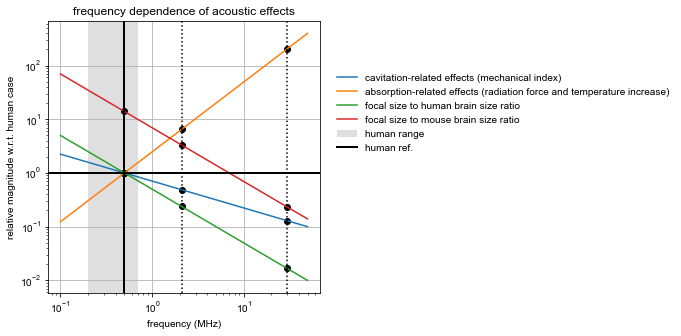

In [10]:
# Set plotting keys for legend
pltkeys = [
    'mechanical index',
    'radiation force',
    'focal size to human brain size ratio',
    'focal size to mouse brain size ratio',
]
mapper = {
    'mechanical index': 'cavitation-related effects (mechanical index)',
    'radiation force': 'absorption-related effects (radiation force and temperature increase)',
}
for k in avg_brain_dims.index:
    ratio_key = f'focal size to {k} brain size ratio'
    mapper[ratio_key] = ratio_key
pltkeys = list(mapper.keys())

# Plot normalized trends
logger.info('plotting frequency dependences')
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_box_aspect(1.)
ax.set_title('frequency dependence of acoustic effects')
ax.set_xscale('log')
ax.set_yscale('log')
rel_metrics[pltkeys].rename(mapper, axis=1).plot(ax=ax)
ax.set_ylabel('relative magnitude w.r.t. human case')
ax.grid('on')
ax.axvspan(*fhuman_bounds, fc='silver', ec='none', alpha=0.5, label='human range')
ax.axvline(fhuman, c='k', lw=2, label='human ref.')
ax.legend(loc=(1.05, 0.5), frameon=False)
ax.axhline(1, c='k', lw=2)

# Label characteristic frequencies
for f, dBvals in target_rel_metrics[pltkeys].iterrows():
    ax.axvline(f, ls=':', c='k')
    ax.scatter([f] * len(dBvals), dBvals.values, c='k')

### Save figure

In [11]:
figsdir = get_data_root(kind=DataRoot.FIG)
fpath = os.path.join(figsdir, 'exposure_vs_freq.pdf')
fig.savefig(fpath)